# Pocc quality assessment feature

## 1. Import code libraries

In [1]:
# Standard code libraries
import os
import platform
import glob

import scipy
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib widget

In [2]:
# Custom code libraries from the ReSurfEMG repository
import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt

from resurfemg.data_connector.tmsisdk_lite import Poly5Reader

from resurfemg.pipelines.pipelines import ecg_removal_gating

from resurfemg.config.config import Config

## Initiation of output folder for experiments

In [3]:
# Root directory for patient data
config = Config()
root_patient_data_directory = \
    config.get_directory('test_data_directory')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

patient_idx = 0

## 2. Load the ventilator and sEMG data

2.a Select a patient

In [4]:
# Select the patient of interest
# Expected data structure:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Measurement_date_XXXX_XX_03
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Patient_02
# -- Measurement_date_XXXX_XX_01
# etc.

# NB Run this cell once per patient!
patient_folders_tmp = \
    glob.glob(root_patient_data_directory + '/**/', recursive=False)

patient_folders = list()
for _, patient_folder in enumerate(patient_folders_tmp):
    patient_folders.append(os.path.normpath(patient_folder))

patients = []
for folder in patient_folders:
    name = folder.split(path_sep)[-1]
    patients.append(name)

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('HSP001',), value='HSP001')

2.b Select a measurement date, or PEEP trial

In [5]:
# Select the PEEP trial of interest for the selected patient
# measurement_date ~ PEEP-trial
 
# NB Run this cell once per patient/PEEP trial combination

patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders_tmp = glob.glob(root_patient_data_directory 
                                + '/' + patient 
                                + '/**/',
                                recursive=False
                                )
measurement_folders = list()
for _, measurement_folder in enumerate(measurement_folders_tmp):
    measurement_folders.append(os.path.normpath(measurement_folder))

measurement_dates = []

for folder in measurement_folders:
    name = folder.split(path_sep)[-1]
    measurement_dates.append(name)

# Initialise the analysis: empty the output parameter list and start at the 
# first recorded PEEP step (index -4)
big_data_list = []
PEEP_step_idx = -4

btn_measurement = widgets.Dropdown(
    options=measurement_dates,
    value=measurement_dates[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('XXXX_XX_XX_measurement_01',), value='XXXX_XX_XX_mea…

2.c Select a PEEP step

In [6]:
# Identify all recordings available for the selected patient/measurement_date

# NB Re-run this cell for each new PEEP trial, as it also empties output 
# parameter list (big_data_list)!

# Identify all PEEP step folders:
measurement_date = btn_measurement.value
date_idx = btn_measurement.index

windows_str = (root_patient_data_directory + '/' + patient + '/' 
               + measurement_date)
root_emg_directory = os.path.join(windows_str)

emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_string = []

for i in range(len(emg_files)):
    list_of_numbers_string.append(emg_files[i].split(path_sep)[-2])

# Select the PEEP step of interest. The selection menu initialises at the third 
# but last (index -4) recording. The PEEP steps are named after the folders 
# containing the data files (.poly5) of interest.

btn_PEEP_step = widgets.Dropdown(
    options=list_of_numbers_string,
    value=str(emg_files[PEEP_step_idx].split(path_sep)[-2]),
    description='Picked File:',
    disabled=False,
)
display(btn_PEEP_step)

Dropdown(description='Picked File:', index=1, options=('000', '001', '002', '003', '004'), value='001')

In [7]:
# Process selected option: the PEEP step of interest  
PEEP_step_chosen = btn_PEEP_step.value
PEEP_step_idx = int(btn_PEEP_step.index)
emg_file_chosen = emg_files[PEEP_step_idx]
vent_file_chosen = vent_files[PEEP_step_idx]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\001\emg_data_synth.Poly5 
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\001\Draeger_data_synth.Poly5


In [8]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
vent_sample_rate = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_sample_rate for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\001\emg_data_synth.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\001\Draeger_data_synth.Poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


## 3. Select the time window of interest

Enter the start and end time of the window in which the occlusions occur. Make sure to take some margin around the peaks in the order of a couple of seconds to allow for the filtering algorithms to work properly. On the other hand, if the window is to broad, the algorithms will also take longer to evaluate.

In [9]:
# Window selection

start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

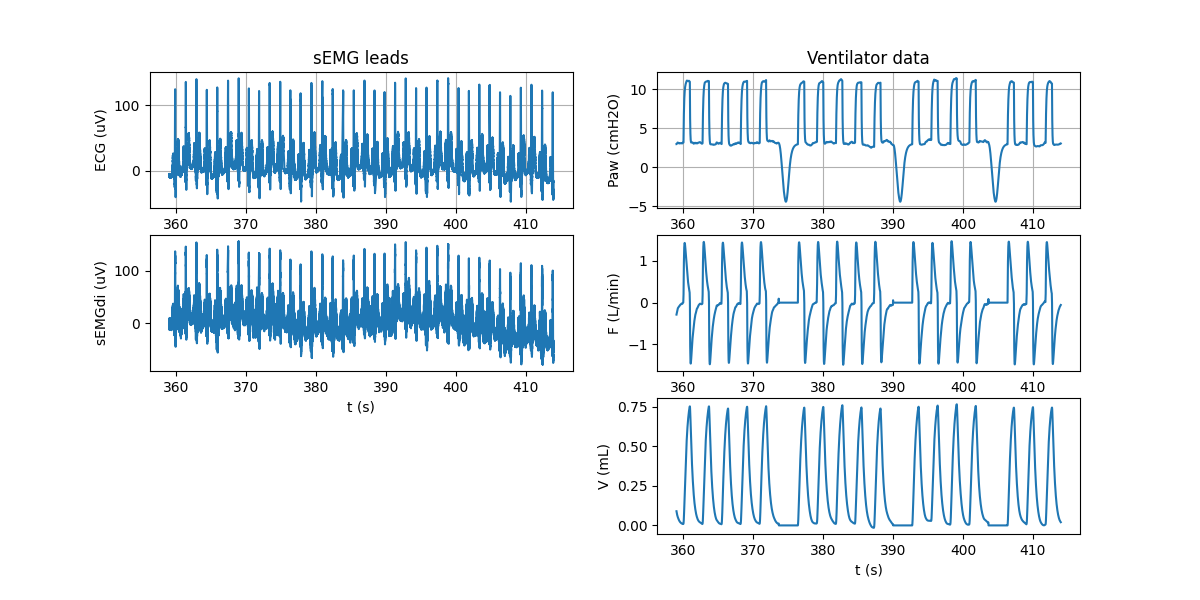

In [10]:
# Plot the selected window if valid start and end times are entered
start = start_widget.value  
end = end_widget.value  
if ((0 > start) | (t_vent[-1] < start) | (0 > end) | (t_vent[-1] < end) 
    | (start >= end)):    
    print('Please make sure that 1) the start and end times are within the'  
          +' limits of the recording and 2) that the start time is before the' 
          + ' end time.')
else:
    # Plot the selected window.
    start_s = int(float(start)* fs_emg)
    end_s = min([int(float(end)*fs_emg), len(y_emg[0,:])-1])
    start_vent_s = int(float(start)* vent_sample_rate)
    end_vent_s = min(
        [int(float(end)* vent_sample_rate), len(y_vent[0,:])-1]
    )

    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg[int(start_s):int(end_s)], 
                    y_emg[0][int(start_s):int(end_s)])
    axis[0, 0].set_ylabel('ECG (uV)')
    axis[1, 0].plot(t_emg[int(start_s):int(end_s)], 
                    y_emg[1][int(start_s):int(end_s)])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')
    
    axis[2, 0].axis('off')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[0][int(start_vent_s):int(end_vent_s)]
    )
    axis[0, 1].set_ylabel('Paw (cmH2O)')
    axis[1, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[1][int(start_vent_s):int(end_vent_s)]
    )
    axis[1, 1].set_ylabel('F (L/min)')
    axis[2, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[2][int(start_vent_s):int(end_vent_s)]
    )
    axis[2, 1].set_ylabel('V (mL)')
    axis[2, 1].set_xlabel('t (s)')

Examine at the selected window:
1. Does it contain all occlusions? If not, adapt the start and/or end time to include all Pocc manoeuvres.
2. Does the window contain limited data before and after the occlusions (~10 s). If noy, you can adapt the start and/or end time to optimise calculation speed.

## 4. Pre-process the sEMGdi

In [11]:
# Set the default pipeline parameters
# Gating settings
gate_width_default = 0.10
gate_threshold_default = 0.30
gate_ECG_shift_default = -10
gate_twice = False

# RMS window
RMS_window_ms_default = 200

# # Peak detection settings
# time_shift_default = 0.5 - RMS_window_ms_default/1000/2
P_occ_prominence_factor_default = 0.8
# sEAdi_prominence_factor_default = 0.5

In [12]:
# Eliminate the baseline wander from the data using a band-pass filter
bd_filtered_file_data = filt.emg_bandpass_butter_sample(
    data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]

In [13]:
# Gating settings

# Window size to plot the gating results from
plot_window = 5         

# QRS peak detection settings
# peak_fraction = 0.30 (default value)
peak_fraction = gate_threshold_default     # Minimal relative peak height
peak_width = 0.001
peak_dist = int(fs_emg/3)

# Shift of gated in samples relative to detected peaks      
# ECG_shift = -10 (default value)
ECG_shift = gate_ECG_shift_default

# Gate width in seconds
# gate_width = 0.10 (default value)
gate_width = gate_width_default

Apply QRS gating

In [14]:
# First run of QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = evl.full_rolling_rms(ecg, 10)
max_ecg_rms = max(
    ecg_rms[int(start_s):int(start_s+plot_window*fs_emg)])
min_ecg_rms = min(
    ecg_rms[int(start_s):int(start_s+plot_window*fs_emg)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*fs_emg, 
    distance=peak_dist
)

# The RMS filter is not centred. Therefore, shift the ECG peak locations
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = filt.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = filt.emg_bandpass_butter_sample(
    processed_data_emg_di, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*fs_emg)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

ECG_gated = ecg_rm.gating(
    ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = ecg_rm.gating(
    emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


In [15]:
ecg_peaks_fun = ecg_rm.detect_ecg_peaks(
    ecg_raw=data_emg_samples[0],
    fs=fs_emg,
    bp_filter=True,
)

ecg_gated_fun = ecg_removal_gating(
    ECG_h20,
    ecg_peaks_fun,
    gate_width_samples, 
    ecg_shift=10,
    )

emg_di_gated_fun = ecg_removal_gating(
    emg_di_h20,
    ecg_peaks_fun,
    gate_width_samples,
    ecg_shift=10,
    )

np.sum(np.abs(emg_di_gated-emg_di_gated_fun))

0.0

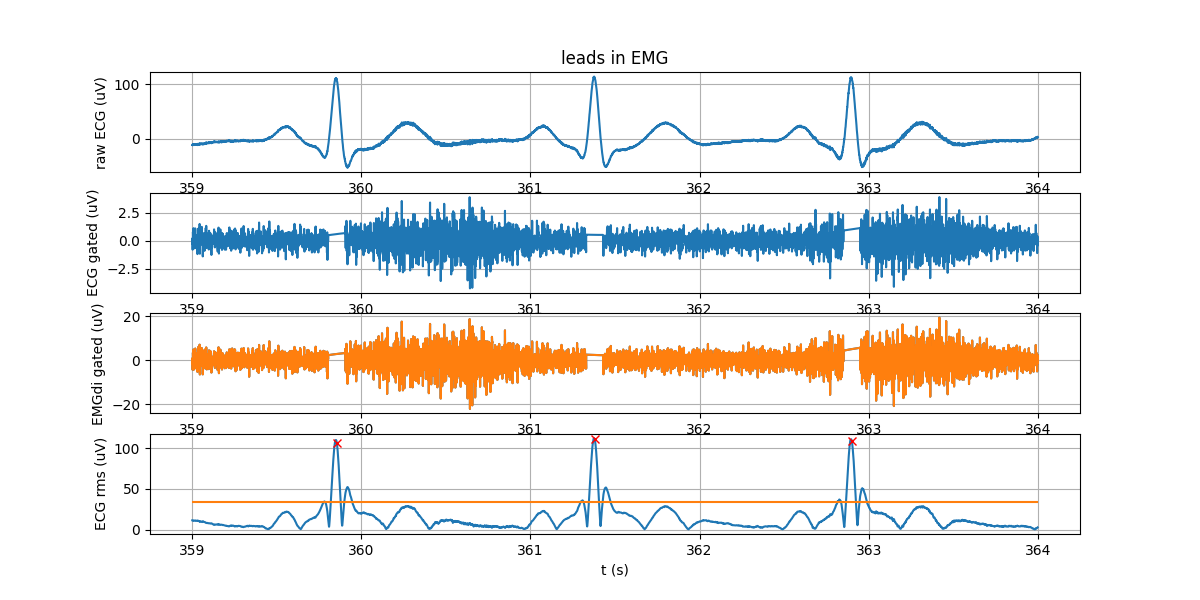

In [16]:
# Plot gating result
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')
axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i], color='tab:blue')
axis[2].plot(t_emg[start_i:end_i], emg_di_gated_fun[start_i:end_i], color='tab:orange')
axis[2].set_ylabel('EMGdi gated (uV)')
axis[3].grid(True)
axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[3].set_ylabel('ECG rms (uV)')
axis[3].hlines(
    y=peak_height, 
    xmin=t_emg[start_i], 
    xmax=t_emg[end_i],
    color = "C1"
)
axis[3].set_xlabel('t (s)')

for idx in range(len(ECG_peaks)):
    if ((ECG_peaks[idx] > int(start_s)) 
        & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
        axis[3].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


In [17]:
# Second run of QRS gating, if selected with gate_twice == True
# This is usefull, e.g., in case of splitted QRS complex or pacing

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = ecg_gated_fun
ecg_rms = evl.full_rolling_rms(ecg_gated_fun, 10)
max_ecg_rms = max(ecg_rms)
min_ecg_rms = min(ecg_rms)
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks_2nd, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*fs_emg, 
    distance=peak_dist
)
# The RMS filter is not centred. Therefore, shift the ECG peak locations
ECG_peaks_2nd = ECG_peaks_2nd - ECG_shift

# Gate ECG and EMG signal
# Fill methods: 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*fs_emg)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)


ECG_gated_twice = ecg_rm.gating(
    ecg_gated_fun, ECG_peaks_2nd, gate_width=gate_width_samples, method=3)
emg_di_gated_twice = ecg_rm.gating(
    emg_di_gated_fun, ECG_peaks_2nd, gate_width=gate_width_samples, method=3)

In [18]:
ecg_peaks_fun_twice = ecg_rm.detect_ecg_peaks(
    ecg_raw=ecg_gated_fun,
    fs=fs_emg,
    bp_filter=False,
)

ecg_gated_fun_twice = ecg_removal_gating(
    ecg_gated_fun,
    ecg_peaks_fun_twice,
    gate_width_samples, 
    ecg_shift=10,
    )

emg_di_gated_fun_twice = ecg_removal_gating(
    emg_di_gated_fun,
    ecg_peaks_fun_twice,
    gate_width_samples,
    ecg_shift=10,
    )

np.sum(np.abs(emg_di_gated_twice-emg_di_gated_fun_twice))

0.0

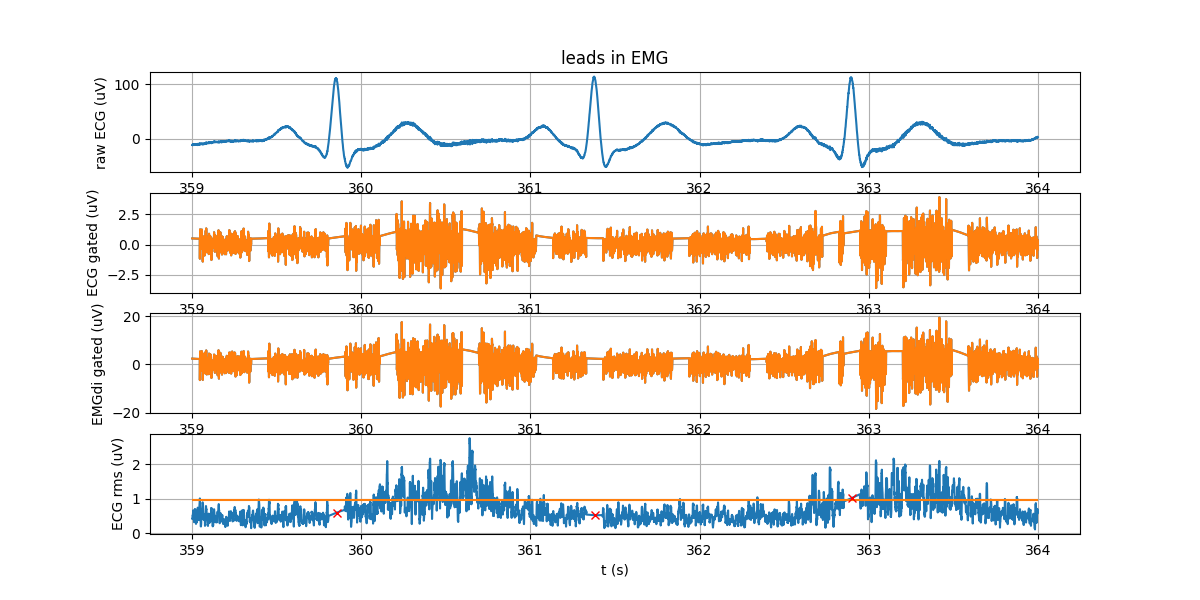

In [19]:
# Plot gating result
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')
axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(t_emg[start_i:end_i], ECG_gated_twice[start_i:end_i], color='tab:blue')
axis[1].plot(t_emg[start_i:end_i], ecg_gated_fun_twice[start_i:end_i], color='tab:orange')
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(t_emg[start_i:end_i], emg_di_gated_twice[start_i:end_i], color='tab:blue')
axis[2].plot(t_emg[start_i:end_i], emg_di_gated_fun_twice[start_i:end_i], color='tab:orange')
axis[2].set_ylabel('EMGdi gated (uV)')
axis[3].grid(True)
axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[3].set_ylabel('ECG rms (uV)')
axis[3].hlines(
    y=peak_height, 
    xmin=t_emg[start_i], 
    xmax=t_emg[end_i],
    color = "C1"
)
axis[3].set_xlabel('t (s)')

for idx in range(len(ECG_peaks)):
    if ((ECG_peaks[idx] > int(start_s)) 
        & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
        axis[3].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')
